## Import des librairies ##

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import History,LearningRateScheduler
from  tensorflow.keras.layers import Dropout,Dense,Activation
print('TensorFlow %s, Keras %s, numpy %s, pandas %s'%(tf.__version__,keras.__version__, np.__version__,pd.__version__))
__DEBUG__=False


TensorFlow 1.10.1, Keras 2.1.6-tf, numpy 1.14.5, pandas 0.23.4


## Paramètres ##

In [2]:
## Structure du réseau et nombre d'epochs (nombre de fois où on passe sur le DataSet)
num_hidden_layers=4
first_layer_size = 128
other_layer_size = 512
epochs=200

###Valeurs A tester dans la cross validation
lst_init_learning_rate = [0.01,0.003, 0.1] 
lst_dropout_prob=[0.15,0.05]
n_splits=10

## Fonctions ##

In [3]:
#Calcule les valeurs min/max et moyennes de chaque colonne dans lst_cols du dataframe pandas  df
def get_columns_metadata(df, lst_cols):            
     header_df = pd.DataFrame( data = lst_cols, columns=['var_name'])    
     header_df['mean']=df[lst_cols].mean().values
     header_df['min']= df[lst_cols].min().values
     header_df['max']= df[lst_cols].max().values
     header_df.set_index('var_name',inplace=True)
     return header_df

#Normalisation de chaque colonne du dataframe pandas  df en utilisant les valeurs de header_df
def normalize(df,header_df):
    for col in df.columns:        
        if col in header_df.index : 
            valmin = header_df["min"][col]
            valmax = header_df["max"][col]
            valmoy = header_df["mean"][col]
            df[col] = 2*((df[col] - valmoy)/(valmax - valmin))
            

## lecture des données ##

In [4]:
# La fonction pandas pd.read_csv permet de créer un objet Dataframe à partir d'un csv

# Données avec labels
train = pd.read_csv('Data/passagers.csv', header = 0, dtype={'Age': np.float64})
# Données de tests sans label. Les prédictions de survie seront envoyées à kaggle
test  = pd.read_csv('Data/test.csv' , header = 0, dtype={'Age': np.float64})
# On réunit les données dans une liste (pour pouvoir boucler sur les 2 dataframes)
full_data = [train, test]
#On garde les passagers ID des données test, car on en aura besoin pour le fichiers résultats de kaggle (voir l'exemple gender_submission.csv)
finalfile_index=test.PassengerId #Index des données de test pour le résultat final

#La fonction info() permet de répérer les colonnes avec des valeurs nulles
print('\nTrain data:')
train.info()
print('\nTest data:')
test.info()


Train data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB

Test data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare    

# Analyse des données #

## 1. Pclass ##
Impact de la classe sur la Survie.

In [5]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


## 2. Sex ##
Impact du genre sur la Survie.

In [6]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


## 3. SibSp and Parch ##
Impacte de la taille de la famille.

In [7]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


Introduction d'une distinction sur les personnes seules

In [8]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


## 4. Embarked ##
Impact du Port d'embarquement sur la Survie.

In [9]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


## 5. Fare ##
On remplace les valeurs manquantes par la moyenne. Puis on regarde l'impact du prix du ticket

In [10]:
for dataset in full_data:
    dataset.loc[dataset.Fare.isnull(), 'Fare'] = train['Fare'].mean()
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


## 6. Age ##
Pour les valeurs vides, on gnère des ages aléatoires entre (mean - std) and (mean + std).
Ensuite on analyse l'impact

In [11]:
for dataset in full_data:
    age_avg = dataset['Age'].mean() # Calcul de la valeur moyenne
    age_std = dataset['Age'].std()  # Calcul de l'écart type
    age_null_count = dataset['Age'].isnull().sum() # nombre de valuer nulle
    
    #On génère une valeur aléatoire pour chaque valeur nulle, puis on l'arrondit à l'entier
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)   
    dataset.loc[np.isnan(dataset['Age']),'Age'] = age_null_random_list    
    dataset['Age'] = dataset['Age'].astype(int)

#Impact de l'age sur le taux de survie
train['CategoricalAge'] = pd.qcut(train['Age'],5)
print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())


   CategoricalAge  Survived
0  (-0.001, 19.0]  0.461140
1    (19.0, 25.0]  0.314917
2    (25.0, 32.0]  0.386364
3    (32.0, 40.0]  0.385057
4    (40.0, 80.0]  0.365269


# Mise en Forme des données #
### > Remplacement des données textuelles par des données numériques
### > Suppressions des colonnes inutiles (sans impact sur la survie ou créées ci-dessus)###

## ATTENTION : Il faut lancer "Run All Above Selected Cell" dans le menu Run pour pouvoir relancer ce bloc

In [12]:
for dataset in full_data:
    # Traitement variable 'Sex'
    dataset['Sex'].replace('female',0,inplace=True )
    dataset['Sex'].replace('male',1,inplace=True)
    
   # Traitement variable 'Embarked'
    dataset['Embarked'].replace('S',0,inplace=True)
    dataset['Embarked'].replace('C',1,inplace=True)
    dataset['Embarked'].replace('Q',2,inplace=True)    

# Suppression des colonnes inutiles (Traitements différents sur Train et Test => on ne peut pas mettre ces instruction dans la boucle)
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

### N'oubliez pas de mettre à jour la fonction normalize !
header_df=get_columns_metadata(train,list(train.columns.values)) 
print(header_df)
normalize(train,header_df)

test  = test.drop(drop_elements, axis = 1)
normalize(test,header_df)

print('\nTrain data:')
print (train.head(10))
print('\nTest data:')
print (test.head(10))

               mean  min       max
var_name                          
Survived   0.383838  0.0    1.0000
Pclass     2.308642  1.0    3.0000
Sex        0.647587  0.0    1.0000
Age       29.637486  0.0   80.0000
Fare      32.204208  0.0  512.3292
Embarked   0.361392  0.0    2.0000
IsAlone    0.602694  0.0    1.0000

Train data:
   Survived    Pclass       Sex       Age      Fare  Embarked   IsAlone
0 -0.767677  0.691358  0.704826 -0.190937 -0.097415 -0.361392 -1.205387
1  1.232323 -1.308642 -1.295174  0.209063  0.152555  0.638608 -1.205387
2  1.232323  0.691358 -1.295174 -0.090937 -0.094780 -0.361392  0.794613
3  1.232323 -1.308642 -1.295174  0.134063  0.081572 -0.361392 -1.205387
4 -0.767677  0.691358  0.704826  0.134063 -0.094292 -0.361392  0.794613
5 -0.767677  0.691358  0.704826 -0.290937 -0.092698  1.638608  0.794613
6 -0.767677 -1.308642  0.704826  0.609063  0.076741 -0.361392  0.794613
7 -0.767677  0.691358  0.704826 -0.690937 -0.043446 -0.361392 -1.205387
8  1.232323  0.691358 -1

## Création du modèle et initialisation Training ##

In [13]:
def set_model(init_learning_rate,dropout_prob):
    #Architecture du réseau
    model = keras.Sequential()
    model.add(keras.layers.Dense(first_layer_size, activation='relu'))
    
### Ajouter ici une ligne  pour gérer le sur-apprentissage (fait)
    model.add(Dense(64, input_dim=64,kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
    
    #Couches cachées (Hidden Layers)
    for i in range(num_hidden_layers):
        # Adds a densely-connected layer  to the model:
        model.add(keras.layers.Dense(other_layer_size, activation='relu'))
### Ajouter ici une ligne  pour gérer le sur-apprentissage
        model.add(keras.layers.Dropout(dropout_prob))        

    # Couche de Sortie (avec fonction Softmax):
    model.add(keras.layers.Dense(2, activation='softmax'))    
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step,1000, 0.96, staircase=True)
    

### Ici vous pouvez essayer différents algos de descentes de gradients 
    #Définiton de l'optimizer  en charge de la Gradient Descent, de la fonction de coût et de la métrique.
    model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate),#RMSPropOptimizer(learning_rate), #GradientDescentOptimizer(learning_rate),AdamOptimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Vérification du Sur-Apprentissage ##

('position_validation_data=', 712)
['acc', 'loss', 'val_acc', 'val_loss']


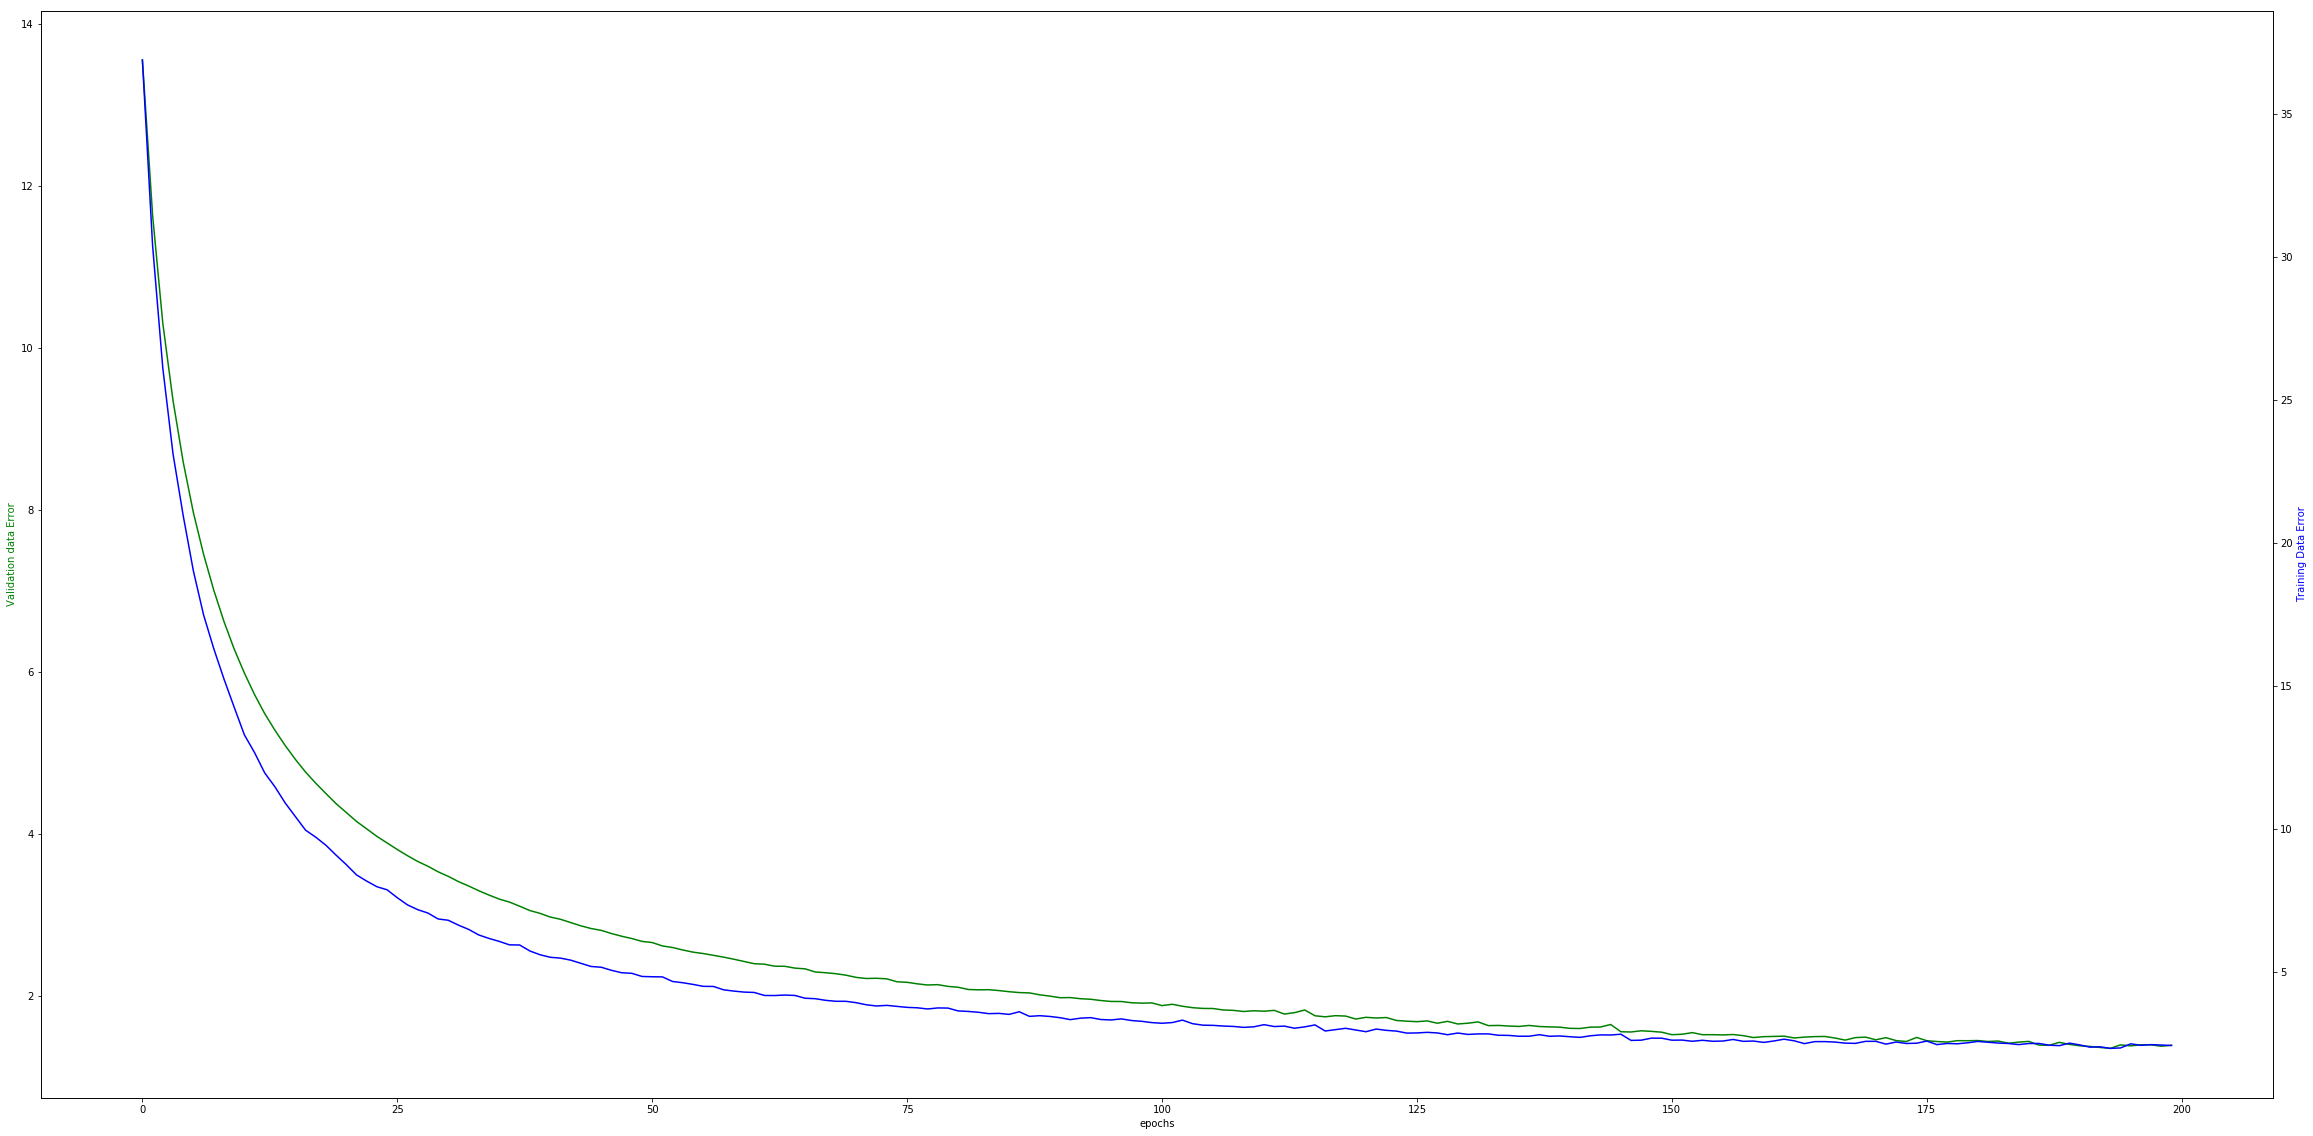

In [19]:

###Essayez Différents jeu de paramètre pour réduire le sur-appentissage
init_learning_rate=0.003
dropout_prob= 0.15
check_epochs=200
pourcentage_validation= 0.2

#A partir des données Train, on sépare features (X)  et labels "Survived"
lst_col=list(train.columns.values)
lst_col.remove('Survived')
X=train[lst_col]
y=train['Survived']

# On calcule la position de la séparation pour une répartition 80/20
position_validation_data=int(train.shape[0] * (1-pourcentage_validation))
print('position_validation_data=',position_validation_data)

# Construction des Features pour l'apprentissage et la validation.  Transformation du Dataframe Pandas en Numpy Array (attendu par Keras) 
X_train, X_val = X[lst_col][:position_validation_data].values, X[lst_col][position_validation_data:].values

# Construction des Labels pour l'apprentissage et la validation.  Hot Encoding 
y_train, y_val = np.transpose([1-y[:position_validation_data], y[:position_validation_data]]), \
                  np.transpose([1-y[position_validation_data:], y[position_validation_data:]]) 


#Construction du modèle en appelant la fonction set_model
model = set_model(init_learning_rate,dropout_prob) 
#définition d'une fonction History pour récupérer la fonction de coût et la métrique à chaque epoch.
hist = History()
model.fit(X_train, y_train, epochs=check_epochs, batch_size=512,validation_data=(X_val, y_val),verbose=False, callbacks=[hist])

print(hist.history.keys())

plt.rcParams["figure.figsize"] = (40,20)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(hist.history['val_loss'], color= 'g')
ax2.plot(hist.history['loss'], color= 'b')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Validation data Error', color='g')
ax2.set_ylabel('Training Data Error', color='b')
plt.show()
                                 

## Fonction de cross validation ##

In [15]:
#Pour un modèle  donné, on exécute la cross validation en utilisant un objet sss sklearn StratifiedShuffleSplit
def cv_run(model, name, sss):  
    loop=1
    for train_index, test_index in sss.split(X, y):
### A vous de completer les 2 lignes ci-dessous.
### Il faut extraire les données d'apprentissage et de test des données du dataframe train en utilisant les index renvoyé par la fonction split
### Vous pouvez vous inspirer du code du bloc "Vérification du Sur-Apprentissage"
         X_train, X_val =  X[train_index], X[test_index]    
         y_train, y_val = np.transpose([1-y[train_index], y[train_index]]), \
                  np.transpose([1-y[test_index], y[test_index]])

# Apprentissage et évaluation        
    hist = History()
    model.fit(X_train, y_train, epochs=epochs, batch_size=32,validation_data=(X_val, y_val),verbose=False, callbacks=[hist])
    [loss, acc] = model.evaluate(X_val, y_val, batch_size=32,verbose=False)    

#Ajout de la performance dans les dictionnaires "loss_dict" et "acc_dict"
    if name in acc_dict:
        acc_dict[name] += acc
        loss_dict[name] += loss
    else:
        acc_dict[name] = acc
        loss_dict[name] = loss
#Affichage de l'avancement
    print(loop,':',[loss, acc])
    loop+=1    

## Hyperparametrage ##
### Ce traitement va être long. Commencer par une faible valeur du paramètre epochs

In [16]:
#Données utilisées pour la méthode split de l'objet StratifiedShuffleSplit
X = train.values[0::, 1::]
y = train.values[0::, 0]

#Créatio d'un dictionnaire pour stocker les modèles
model_dict={}

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=0)

#Créatio d'un dataframe pour logger les résultatsc
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

#Boucle sur des valeurs de init_learning_rate et de dropout_prob
for init_learning_rate in lst_init_learning_rate:
    for dropout_prob in  lst_dropout_prob :
        #Initialisation des dictionnaires utilisés dans la cross validation 
        acc_dict = {}
        loss_dict = {}
        #Construction du nom du modèle, en fonction des paramètres
        name="lr_%s_do_%s"%(init_learning_rate,dropout_prob)
        #Création de l'objet modèle
        model = set_model(init_learning_rate,dropout_prob) 
        #Ajout du modèle au dico pour sélectionner le meilleur dans le suivant
        model_dict[name]=model
        cv_run(model, name, sss)        
        # Calcul de la performance du modèle comme moyenne pour chaque itération dans cross-validation  
        for clf in acc_dict:
            acc_dict[clf] = acc_dict[clf] / n_splits
            log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
            log = log.append(log_entry)
print (log.values)

(1, ':', [-5.299206161499024, 0.8333333359824286])
(1, ':', [-3.2553109380933973, 0.733333338631524])
(1, ':', [-4.3846966637505425, 0.8444444457689921])
(1, ':', [-2.214252249399821, 0.7888888902134366])
(1, ':', [0.4976396083831787, 0.6111111097865635])
(1, ':', [-3.163259988360935, 0.8111111137602064])
[['lr_0.01_do_0.15' 0.08333333359824287]
 ['lr_0.01_do_0.05' 0.0733333338631524]
 ['lr_0.003_do_0.15' 0.08444444457689922]
 ['lr_0.003_do_0.05' 0.07888888902134365]
 ['lr_0.1_do_0.15' 0.06111111097865635]
 ['lr_0.1_do_0.05' 0.08111111137602064]]


# Prediction #
Maintenant on utilise le meilleur jeu de paramètre pour faire la prédiction

In [18]:
###A vous de completer les 3 lignes ci-dessous, sans oublier la normalisation !
### Analyser les résultats du bloc précédent pour choisir le meilleur paramètre
best_model = model_dict["lr_0.003_do_0.15"]
X = train.values[0::, 1::]
y = train.values[0::, 0]

y_hot = np.transpose([1-y, y])

#Apprentissage sur toutes les données, avec le modèle sélectionné
best_model.fit(X,y_hot, epochs=epochs, batch_size=32,verbose=False)
print(pd.DataFrame(best_model.evaluate(X, y_hot, batch_size=32,verbose=False),index=model.metrics_names))

#Inférence des données du fichier test et Construction du fichier à envoyer à Kaggle 
prediction=best_model.predict(test.values, batch_size=32)
results=pd.DataFrame(np.argmax(prediction,axis=1), index = finalfile_index, columns=['Survived'])
results.to_csv('resultats.csv')
print(results.sum())
results.describe()

             0
loss -4.672444
acc   0.831650
Survived    126
dtype: int64


,Survived
count,418.000000
mean,0.301435
std,0.459431
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000
